In [1]:
import tensorflow as tf### models
import numpy as np### math computations
import matplotlib.pyplot as plt### plots
# import sklearn### machine learning library
# import cv2## image processing
# from sklearn.metrics import confusion_matrix, roc_curve### metrics
import seaborn as sns### visualizations
import datetime
import io
import os
import random
# from google.colab import files
from PIL import Image
# import albumentations as A
import tensorflow_datasets as tfds
# import tensorflow_probability as tfp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, InputLayer, BatchNormalization, Input, Dropout, RandomFlip, RandomRotation, Resizing, Rescaling
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives, Precision, Recall, AUC, binary_accuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, CSVLogger, EarlyStopping, LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers  import L2, L1
from tensorboard.plugins.hparams import api as hp
# from google.colab import drive

c:\Users\z644252\AppData\Local\mambaforge\envs\learn_tf\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Wandb Install, Login, Initialization and Configuration

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 27.1 MB/s 
     |████████████████████████████████| 181 kB 64.4 MB/s 
     |████████████████████████████████| 158 kB 56.1 MB/s 
     |████████████████████████████████| 63 kB 1.7 MB/s 
     |████████████████████████████████| 157 kB 8.5 MB/s 
     |████████████████████████████████| 157 kB 63.1 MB/s 
     |████████████████████████████████| 157 kB 57.5 MB/s 
     |████████████████████████████████| 157 kB 58.3 MB/s 
     |████████████████████████████████| 157 kB 58.9 MB/s 
     |████████████████████████████████| 157 kB 57.4 MB/s 
     |████████████████████████████████| 157 kB 62.8 MB/s 
     |████████████████████████████████| 156 kB 56.0 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=2e9b4ce856f8fd3e8af4d8092d480ae0e5fb73e6183da07d38081b80ba4b350c
  Stored in directory: /root/.cache/pip/wheels/3e/31/

In [ ]:
import wandb
from wandb.keras import WandbCallback

In [ ]:
!wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 

In [ ]:
wandb.init(project="Malaria-Detection", entity="neuralearn")

###wandb.tensorboard.patch(root_logdir="./logs")
#wandb.init(project="Malaria-Detection", entity="neuralearn", sync_tensorboard=True)

In [ ]:
wandb.config = {
  "LEARNING_RATE": 0.001,
  "N_EPOCHS": 5,
  "BATCH_SIZE": 128,
  "DROPOUT_RATE": 0.0,
  "IM_SIZE": 224,
  "REGULARIZATION_RATE": 0.0,
  "N_FILTERS": 6,
  "KERNEL_SIZE": 3,
  "N_STRIDES": 1,
  "POOL_SIZE": 2,
  "N_DENSE_1": 100,
  "N_DENSE_2": 10,
}
CONFIGURATION = wandb.config

# Data Preparation

## Data Loading

In [2]:
dataset, dataset_info = tfds.load('malaria', with_info=True,
                                  as_supervised=True, 
                                  shuffle_files = True, 
                                  split=['train'])

In [3]:
for data in dataset[0].take(1):
  print(data)

(<tf.Tensor: shape=(145, 148, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)>, <tf.Tensor: shape=(), dtype=int64, numpy=1>)


In [4]:
for i in dataset.take(1):
  print(i)

AttributeError: 'list' object has no attribute 'take'

In [7]:
#dataset_info

In [5]:
def splits(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
  DATASET_SIZE = len(dataset)

  train_dataset = dataset.take(int(TRAIN_RATIO*DATASET_SIZE))

  val_test_dataset = dataset.skip(int(TRAIN_RATIO*DATASET_SIZE))
  val_dataset = val_test_dataset.take(int(VAL_RATIO*DATASET_SIZE))

  test_dataset = val_test_dataset.skip(int(VAL_RATIO*DATASET_SIZE))
  return train_dataset, val_dataset, test_dataset

In [6]:
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

train_dataset, val_dataset, test_dataset = splits(dataset[0], TRAIN_RATIO, VAL_RATIO, TEST_RATIO )
#print(list(train_dataset.take(1).as_numpy_iterator()),
 #     list(val_dataset.take(1).as_numpy_iterator()), list(test_dataset.take(1).as_numpy_iterator()))

In [7]:
train_dataset

<TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

## Dataset Visualization

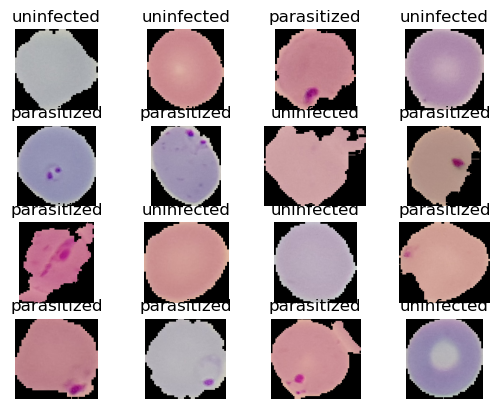

In [8]:
for i, (image, label) in enumerate(train_dataset.take(16)):
  ax = plt.subplot(4, 4, i + 1)
  
  plt.imshow(image)
  plt.title(dataset_info.features['label'].int2str(label))
  plt.axis('off')

In [ ]:
# for i, (image, label) in enumerate(train_dataset.take(2)):
#   plt.subplot(1, 4, 2*i + 1)
#   plt.imshow(image)

#   plt.subplot(1, 4, 2*i + 2)
#   plt.imshow(tf.image.adjust_saturation(image, 0.3))


#   plt.title(dataset_info.features['label'].int2str(label))
#   plt.axis('off')

In [9]:
dataset_info.features['label'].int2str(1)

'uninfected'

## Data Preprocessing

### Data Augmentation

In [ ]:
def visualize(original, augmented):
  plt.subplot(1,2,1)
  plt.imshow(original)

  plt.subplot(1,2,2)
  plt.imshow(augmented)

In [ ]:
original_image, label = next(iter(train_dataset))

In [ ]:
augmented_image = tf.image.adjust_saturation(original_image, saturation_factor = 0.3)#central_crop(original_image, 0.8)

In [ ]:
visualize(original_image, augmented_image)

In [ ]:
IM_SIZE = 224

In [ ]:
original_image, label = next(iter(train_dataset))
@tf.function
def resize_rescale(image, label):
  #print("I was here")
  #tf.print("I was here")
  return tf.image.resize(image, (IM_SIZE, IM_SIZE))/255.0, label

_, _ = resize_rescale(original_image, label)
_, _ = resize_rescale(original_image, label)

In [ ]:
#tf.config.run_functions_eagerly(False)

In [ ]:
### tf.keras.layer resizing and rescaling
resize_rescale_layers = tf.keras.Sequential([
       Resizing(IM_SIZE, IM_SIZE),
       Rescaling(1./255),                               
])

In [ ]:
### tf.image augment
@tf.function
def augment(image, label):
  image, label = resize_rescale(image, label)

  image = tf.image.rot90(image)
  #image = tf.image.adjust_saturation(image, saturation_factor = 0.3)
  image = tf.image.flip_left_right(image)

  return image, label

In [ ]:
class RotNinety(Layer):
  def __init__(self):
    super().__init__()
    
  @tf.function
  def call(self, image):
    return tf.image.rot90(image)

In [ ]:
### tf.keras.layer augment
augment_layers = tf.keras.Sequential([
       RandomRotation(factor = (0.25, 0.2501),),
       RandomFlip(mode='horizontal',),
       RandomContrast(factor=0.1),
                                  
])

@tf.function
def augment_layer(image, label):
  return augment_layers(resize_rescale_layers(image), training = True), label

### Data Loading

In [ ]:
BATCH_SIZE = 32

In [ ]:
test_dataset = test_dataset.map(resize_rescale, num_parallel_calls = tf.data.AUTOTUNE)
#train_dataset

In [ ]:
# for image,label in train_dataset.take(1):
#   print(image, label)

In [ ]:

train_dataset = (
    train_dataset
    .shuffle(buffer_size = 1024, reshuffle_each_iteration = True)
    .map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
val_dataset = (
    val_dataset
    .shuffle(buffer_size = 32)
    .map(resize_rescale, num_parallel_calls = tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
)

In [ ]:
val_dataset

In [ ]:
train_dataset

### MIxup Data Augmentation

In [ ]:
train_dataset_1 = train_dataset.shuffle(buffer_size = 4096, ).map(resize_rescale, num_parallel_calls = tf.data.AUTOTUNE)
train_dataset_2 = train_dataset.shuffle(buffer_size = 4096, ).map(resize_rescale, num_parallel_calls = tf.data.AUTOTUNE)

mixed_dataset = tf.data.Dataset.zip((train_dataset_1, train_dataset_2))

In [ ]:
def mixup(train_dataset_1, train_dataset_2):
  (image_1,label_1), (image_2, label_2) = train_dataset_1, train_dataset_2

  lamda = tfp.distributions.Beta(0.2,0.2)
  lamda = lamda.sample(1)[0]
  
  image = lamda*image_1 + (1-lamda)*image_2
  label = lamda*tf.cast(label_1, dtype = tf.float32) + (1-lamda)*tf.cast(label_2, dtype = tf.float32)
  return image, label

In [ ]:
BATCH_SIZE = 32
train_dataset = (
    mixed_dataset
    .shuffle(buffer_size = 4096, reshuffle_each_iteration = True)
    .map(mixup, num_parallel_calls = tf.data.AUTOTUNE)
    #map(cutmix, num_parallel_calls = tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
train_dataset

### CutMix Data *Augmentation*

In [ ]:
def box(lamda):
  
  r_x = tf.cast(tfp.distributions.Uniform(0, IM_SIZE).sample(1)[0], dtype = tf.int32)
  r_y = tf.cast(tfp.distributions.Uniform(0, IM_SIZE).sample(1)[0], dtype = tf.int32)

  r_w = tf.cast(IM_SIZE*tf.math.sqrt(1-lamda), dtype = tf.int32)
  r_h = tf.cast(IM_SIZE*tf.math.sqrt(1-lamda), dtype = tf.int32)

  r_x = tf.clip_by_value(r_x - r_w//2, 0, IM_SIZE)
  r_y = tf.clip_by_value(r_y - r_h//2, 0, IM_SIZE)

  x_b_r = tf.clip_by_value(r_x + r_w//2, 0, IM_SIZE)
  y_b_r = tf.clip_by_value(r_y + r_h//2, 0, IM_SIZE)

  r_w = x_b_r - r_x
  if(r_w == 0):
    r_w  = 1

  r_h = y_b_r - r_y
  if(r_h == 0):
    r_h = 1

  return r_y, r_x, r_h, r_w

In [ ]:
def cutmix(train_dataset_1, train_dataset_2):
  (image_1,label_1), (image_2, label_2) = train_dataset_1, train_dataset_2

  lamda = tfp.distributions.Beta(0.2,0.2)
  lamda = lamda.sample(1)[0]
  
  r_y, r_x, r_h, r_w = box(lamda)
  crop_2 = tf.image.crop_to_bounding_box(image_2, r_y, r_x, r_h, r_w)
  pad_2 = tf.image.pad_to_bounding_box(crop_2, r_y, r_x, IM_SIZE, IM_SIZE)

  crop_1 = tf.image.crop_to_bounding_box(image_1, r_y, r_x, r_h, r_w)
  pad_1 = tf.image.pad_to_bounding_box(crop_1, r_y, r_x, IM_SIZE, IM_SIZE)

  image = image_1 - pad_1 + pad_2

  lamda = tf.cast(1- (r_w*r_h)/(IM_SIZE*IM_SIZE), dtype = tf.float32)
  label = lamda*tf.cast(label_1, dtype = tf.float32) + (1-lamda)*tf.cast(label_2, dtype = tf.float32)

  return image, label

In [ ]:
original_image, label = next(iter(train_dataset))
print(label)
plt.imshow(original_image[0])

### Albumentations

In [ ]:
!pip install -U git+https://github.com/albu/albumentations --no-cache-dir

In [ ]:
transforms = A.Compose(
    [
      A.Resize(IM_SIZE, IM_SIZE),

      A.OneOf([A.HorizontalFlip(),
                A.VerticalFlip(),], p = 0.3),
      
      A.RandomRotate90(),   
      #A.RandomGridShuffle(grid=(3, 3), always_apply=False, p=0.5),
      A.RandomBrightnessContrast(brightness_limit=0.2,
                                contrast_limit=0.2,
                                always_apply=False, p=0.5),
      #A.Cutout(num_holes=8, max_h_size=8, max_w_size=8, fill_value=0, always_apply=False, p=0.5),
      A.Sharpen(alpha=(0.2, 0.5), lightness=(0.5, 1.0), always_apply=False, p=0.5),
])

In [ ]:
def aug_albument(image):
  data = {"image":image}
  image = transforms(**data)
  image = image["image"]
  image = tf.cast(image/255., tf.float32)
  return image

In [ ]:
def process_data(image, label):
    aug_img = tf.numpy_function(func=aug_albument, inp=[image], Tout=tf.float32)
    return aug_img, label

In [ ]:
train_dataset = (
    train_dataset
    .shuffle(buffer_size = 1024, reshuffle_each_iteration = True)
    .map(process_data)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
train_dataset

In [ ]:
im, _ = next(iter(train_dataset))
plt.imshow(im[0])

In [ ]:
plt.figure(figsize=(15,15))

for i in range(1,32):
  plt.subplot(8,4,i)
  plt.imshow(im[i])

### Repeating the dataset (x5)

In [ ]:
def augment_1(image, label):
  image, label = resize_rescale(image, label)

  image = tf.image.random_brightness(image, 0.2)
  return image, label

In [ ]:
def augment_2(image, label):
  image, label = resize_rescale(image, label)

  image = tf.image.random_flip_up_down(image)
  return image, label

In [ ]:
def augment_3(image, label):
  image, label = resize_rescale(image, label)

  image = tf.image.flip_left_right(image)
  return image, label

In [ ]:
def augment_4(image, label):
  image, label = resize_rescale(image, label)

  image = tf.image.rot90(image)
  return image, label

In [ ]:
def augment_5(image, label):
  image, label = resize_rescale(image, label)
  
  return image, label

In [ ]:
train_dataset_1 = (
    train_dataset
    .shuffle(buffer_size = 1024, reshuffle_each_iteration = True)
    .map(augment_1)
)

In [ ]:
train_dataset_2 = (
    train_dataset
    .shuffle(buffer_size = 1024, reshuffle_each_iteration = True)
    .map(augment_2)
)

In [ ]:
train_dataset_3 = (
    train_dataset
    .shuffle(buffer_size = 1024, reshuffle_each_iteration = True)
    .map(augment_3)
)

In [ ]:
train_dataset_4 = (
    train_dataset
    .shuffle(buffer_size = 1024, reshuffle_each_iteration = True)
    .map(augment_4)
)

In [ ]:
train_dataset_5 = (
    train_dataset
    .shuffle(buffer_size = 1024, reshuffle_each_iteration = True)
    .map(augment_5)
)

In [ ]:
full_dataset = train_dataset_1.concatenate(train_dataset_2).concatenate(train_dataset_3).concatenate(train_dataset_4).concatenate(train_dataset_5)

In [ ]:
full_dataset = (
    full_dataset
    .shuffle(buffer_size = 1024, reshuffle_each_iteration = True)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
full_dataset

## WandB Dataset Versioning

### Data Loading

In [ ]:
dataset, dataset_info = tfds.load('malaria', with_info=True, as_supervised=True, shuffle_files = True, split=['train'])

print(dataset)

In [ ]:
k = 0
for data in dataset[0]:
  
  with open('dataset/malaria_dataset_'+str(k) + '.npz', mode = 'wb') as file:
      np.savez(file, data)
  k += 1
  if(k%1000 == 0):
    print(k)


In [ ]:
def load_original_data():
  with wandb.init(project="Malaria-Detection", entity="neuralearn") as run:
    
    original_data = wandb.Artifact(
        name = "new_dataset", 
        type="raw_data",
        description = "The Malaria dataset contains a total of 27,558 cell images with equal instances of parasitized and uninfected cells from the thin blood smear slide images of segmented cells.",
        metadata = {"source": "TFDS",
                    "homepage": "https://lhncbc.nlm.nih.gov/publication/pub9932",
                    "source_code": "tfds.image_classification.Malaria",
                    "version": "1.0.0",
                    "download_size": "337.08 MiB",
                    }
    )
    
    original_data.add_dir('dataset/')

    run.log_artifact(original_data)

In [ ]:
load_original_data()

### Data Preprocessing

In [ ]:
with wandb.init(project="Malaria-Detection", entity="neuralearn") as run:    
  artifact = run.use_artifact('neuralearn/Malaria-Detection/new_dataset:v1', type='raw_data')
  artifact_dir = artifact.download()

In [ ]:
IM_SIZE = 224
def resize_rescale(image):
  return tf.image.resize(image, (IM_SIZE, IM_SIZE))/255.0

In [ ]:
def preprocess_data():
  with wandb.init(project="Malaria-Detection", entity="neuralearn") as run:

    artifact = run.use_artifact('neuralearn/Malaria-Detection/new_dataset:v1', type='raw_data')
    artifact_dir = artifact.download()

    preprocessed_data = wandb.Artifact(
        name = "preprocessed_dataset", 
        type="preprocessed_data",
        description = "A Preprocessed version of the Malaria dataset",
        
    )

    artifact_directory = "artifacts/new_dataset:v1/"

    dataset_x = []
    dataset_y = []
    
    for f in os.listdir(artifact_directory)[:1000]:
      with open(artifact_directory + f, 'rb') as file:
        npz_array = np.load(file, allow_pickle = True)
        
        x,y = npz_array.f.arr_0

        dataset_x.append(resize_rescale(x))
        dataset_y.append(y)
    
    #dataset = tf.data.Dataset.from_tensor_slices((dataset_x, dataset_y))

    with preprocessed_data.new_file("prep_dataset.npz", mode = "wb") as file:
        np.savez(file, [dataset_x, dataset_y])
    run.log_artifact(preprocessed_data)

In [ ]:
preprocess_data()

### Data Splitting

In [ ]:
run = wandb.init()
artifact = run.use_artifact('neuralearn/Malaria-Detection/preprocessed_dataset:v2', type='preprocessed_data')
artifact_dir = artifact.download()

In [ ]:
def split_data():
  with wandb.init(project="Malaria-Detection", entity="neuralearn") as run:

    artifact = run.use_artifact('neuralearn/Malaria-Detection/preprocessed_dataset:v2', type='preprocessed_data')
    artifact_dir = artifact.download()

    train_data = wandb.Artifact(
        name = "train_dataset", 
        type="preprocessed_data",
        description = "Training dataset",
        
    )
    val_data = wandb.Artifact(
        
        name = "val_dataset", 
        type="preprocessed_data",
        description = "Validation dataset",
            
        )
    test_data = wandb.Artifact(
        name = "test_dataset", 
        type="preprocessed_data",
        description = "Test dataset",
            
        )
    
    artifact_file = "artifacts/preprocessed_dataset:v2/prep_dataset.npz"

    with open(artifact_file, 'rb') as file:
      npz_arr = np.load(file, allow_pickle = True)
      arr = npz_arr.f.arr_0

    train_split = 0.8
    val_split = 0.1
    test_split = 0.1
    
    data_len = len(arr[0])

    train_arr = [arr[0][0:int(train_split*data_len)], arr[1][0:int(train_split*data_len)]]
    val_arr = [arr[0][int(train_split*data_len):int((train_split+val_split)*data_len)], arr[1][int(train_split*data_len):int((train_split+val_split)*data_len)] ]
    test_arr = [arr[0][int((train_split+val_split)*data_len):], arr[1][int((train_split+val_split)*data_len):] ]
    
      
    with train_data.new_file("train_dataset.npz", mode = "wb") as file:
        np.savez(file, train_arr)
        
    with val_data.new_file("val_dataset.npz", mode = "wb") as file:
        np.savez(file, val_arr)
        
    with test_data.new_file("test_dataset.npz", mode = "wb") as file:
        np.savez(file, test_arr)
        

    run.log_artifact(train_data)  
    run.log_artifact(val_data)      
    run.log_artifact(test_data)

In [ ]:
split_data()

### Data augmentation

In [ ]:
### tf.image augment
def augment(image):
  image = tf.image.rot90(image)
  image = tf.image.flip_left_right(image)

  return image

In [ ]:
/contertifant/acts/train_dataset:v0/train_dataset.npz

In [ ]:
wandb.finish()

In [ ]:
def augment_data():
  with wandb.init(project="Malaria-Detection", entity="neuralearn") as run:

    artifact = run.use_artifact('neuralearn/Malaria-Detection/train_dataset:v0', type='preprocessed_data')
    artifact_dir = artifact.download()

    augmented_data = wandb.Artifact(
        name = "Augmented_dataset", 
        type="preprocessed_data",
        description = "An Augmented version of the Malaria train dataset",
    )

    artifact_file = "artifacts/train_dataset:v0/train_dataset.npz"
    
    dataset_x = []

    with open(artifact_file, 'rb') as file:
        npz_array = np.load(file, allow_pickle = True)
        
        arr = npz_array.f.arr_0

        for im in arr[0]:
          dataset_x.append(augment(im))
        dataset_y = arr[1]

    with augmented_data.new_file("aug_dataset.npz", mode = "wb") as file:
        np.savez(file, [dataset_x, dataset_y])
    run.log_artifact(augmented_data)

In [ ]:
augment_data()

# Model Creation and Training

## Wandb Model Versioning

### Untrained Model Versioning

In [ ]:
def log_model():
  with wandb.init(project="Malaria-Detection", entity="neuralearn") as run:

    
    untrained_model = wandb.Artifact(
        name = "Untrained_model", 
        type="model",
        description = "The initial version of our lenet model",
        metadata = CONFIGURATION
    )
    filename = 'lenet.h5'
    lenet_model.save(filename)

    untrained_model.add_file(filename)
    wandb.save(filename)
    run.log_artifact(untrained_model)

In [ ]:
log_model()

### Trained Model versioning

In [ ]:
def train_and_log():
  with wandb.init(project="Malaria-Detection", entity="neuralearn") as run:

    artifact = run.use_artifact('neuralearn/Malaria-Detection/Augmented_dataset:v0', type='preprocessed_data')
    artifact_dir = artifact.download()

    trained_sequential_model = wandb.Artifact(
        name = "Trained_Sequential_model", 
        type="model",
        description = "A trained version of our model",
        metadata = CONFIGURATION,
    )

    artifact_file = "artifacts/Augmented_dataset:v0/aug_dataset.npz"
        
    dataset_x = []

    with open(artifact_file, 'rb') as file:
        npz_array = np.load(file, allow_pickle = True)
        
        arr = npz_array.f.arr_0

        for im in arr[0]:
          dataset_x.append(im)
        dataset_y = arr[1]
    

    d_x = tf.convert_to_tensor(dataset_x, dtype = tf.float32)
    d_y = tf.convert_to_tensor(dataset_y, dtype = tf.float32)

    d = tf.data.Dataset.from_tensor_slices((d_x,d_y))

    train_d = (
        d
        .shuffle(buffer_size = 1024, reshuffle_each_iteration = True)
        .batch(BATCH_SIZE)
        .prefetch(tf.data.AUTOTUNE)
    )


    artifact = run.use_artifact('neuralearn/Malaria-Detection/Untrained_model:v0', type='model')
    artifact_dir = artifact.download()

    artifact_file = "artifacts/Untrained_model:v0/lenet.h5"

    lenet_model = tf.keras.models.load_model(artifact_file)

    metrics = [TruePositives(name='tp'),FalsePositives(name='fp'), TrueNegatives(name='tn'), FalseNegatives(name='fn'), 
                BinaryAccuracy(name='accuracy'), Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]

    lenet_model.compile(optimizer = Adam(learning_rate = CONFIGURATION['LEARNING_RATE']),
          loss = BinaryCrossentropy(),
          metrics = metrics)

    lenet_model.fit(
        train_d,
        epochs = 3,
        verbose = 1,
        callbacks=[WandbCallback()],
    )
    
    filename = 'lenet_trained.h5'
    lenet_model.save(filename)

    trained_sequential_model.add_file(filename)
    wandb.save(filename)
    run.log_artifact(trained_sequential_model)

In [ ]:
train_and_log()

## Sequential API

In [ ]:
IM_SIZE = CONFIGURATION['IM_SIZE']
DROPOUT_RATE = CONFIGURATION['DROPOUT_RATE']
REGULARIZATION_RATE = CONFIGURATION['REGULARIZATION_RATE']
N_FILTERS = CONFIGURATION['N_FILTERS']
KERNEL_SIZE = CONFIGURATION['KERNEL_SIZE']
POOL_SIZE = CONFIGURATION['POOL_SIZE']
N_STRIDES = CONFIGURATION['N_STRIDES']

lenet_model = tf.keras.Sequential([
    InputLayer(input_shape = (IM_SIZE, IM_SIZE, 3)),

    Conv2D(filters = N_FILTERS , kernel_size = KERNEL_SIZE, strides = N_STRIDES , padding='valid',
          activation = 'relu',kernel_regularizer = L2(REGULARIZATION_RATE)),
    BatchNormalization(),
    MaxPool2D (pool_size = POOL_SIZE, strides= N_STRIDES*2),
    Dropout(rate = DROPOUT_RATE ),

    Conv2D(filters = N_FILTERS*2 + 4, kernel_size = KERNEL_SIZE, strides=N_STRIDES, padding='valid',
          activation = 'relu', kernel_regularizer = L2(REGULARIZATION_RATE)),
    BatchNormalization(),
    MaxPool2D (pool_size = POOL_SIZE, strides= N_STRIDES*2),

    Flatten(),
    
    Dense( CONFIGURATION['N_DENSE_1'], activation = "relu", kernel_regularizer = L2(REGULARIZATION_RATE)),
    BatchNormalization(),
    Dropout(rate = DROPOUT_RATE),
    
    Dense( CONFIGURATION['N_DENSE_2'], activation = "relu", kernel_regularizer = L2(REGULARIZATION_RATE)),
    BatchNormalization(),

    Dense(1, activation = "sigmoid"),

])

lenet_model.summary()

In [ ]:
def train_and_log():
  with wandb.init(project="Malaria-Detection", entity="neuralearn") as run:

    artifact = run.use_artifact('neuralearn/Malaria-Detection/Augmented_dataset:v0', type='preprocessed_data')
    artifact_dir = artifact.download()

    sequential_model = wandb.Artifact(
        name = "Sequential_model", 
        type="model",
        description = "A trained version of our model",
        
    )

    artifact_file = "artifacts/train_dataset:v0/aug_dataset.npz"
    
    dataset_x = []

    with open(artifact_file, 'rb') as file:
        npz_array = np.load(file, allow_pickle = True)
        
        arr = npz_array.f.arr_0

        for im in arr[0]:
          dataset_x.append(augment(im))
        dataset_y = arr[1]

        # metrics = [TruePositives(name='tp'),FalsePositives(name='fp'), TrueNegatives(name='tn'), FalseNegatives(name='fn'), 
        #             BinaryAccuracy(name='accuracy'), Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]
        # FACTOR = 1
        # LABELS = ['Parasitized', 'Uninfected']


        # lenet_model.compile(optimizer = Adam(learning_rate = CONFIGURATION['LEARNING_RATE']),
        #       loss = BinaryCrossentropy(),
        #       metrics = metrics)

        # history = lenet_model.fit(
        #     train_dataset,
        #     validation_data = val_dataset,
        #     epochs = 23,#CONFIGURATION['N_EPOCHS'],
        #     verbose = 1,
        #     #callbacks=[LogImagesCallbackWandB()]
        #     )

    # with preprocessed_data.new_file("aug_dataset.npz", mode = "wb") as file:
    #     np.savez(file, [dataset_x, dataset_y])

    # run.log_artifact(preprocessed_data)

In [ ]:
train_and_log()

In [ ]:
artifact_file = "artifacts/Augmented_dataset:v0/aug_dataset.npz"
    
dataset_x = []

with open(artifact_file, 'rb') as file:
    npz_array = np.load(file, allow_pickle = True)
    
    arr = npz_array.f.arr_0

    for im in arr[0]:
      dataset_x.append(im)
    dataset_y = arr[1]

In [ ]:
print(dataset_y)

In [ ]:
d_x = tf.convert_to_tensor(dataset_x, dtype = tf.float32)
d_y = tf.convert_to_tensor(dataset_y, dtype = tf.float32)

print(d_x.shape, d_y.shape)

d = tf.data.Dataset.from_tensor_slices((d_x,d_y))

In [ ]:
for i in d.take(2):
  print(i)

In [ ]:
BATCH_SIZE = 32

train_d = (
    d
    .shuffle(buffer_size = 1024, reshuffle_each_iteration = True)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)
print(train_d)

In [ ]:
metrics = [TruePositives(name='tp'),FalsePositives(name='fp'), TrueNegatives(name='tn'), FalseNegatives(name='fn'), 
            BinaryAccuracy(name='accuracy'), Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]
FACTOR = 1
LABELS = ['Parasitized', 'Uninfected']


lenet_model.compile(optimizer = Adam(learning_rate = CONFIGURATION['LEARNING_RATE']),
      loss = BinaryCrossentropy(),
      metrics = metrics)

history = lenet_model.fit(
    train_d,
    #validation_data = val_dataset,
    epochs = 2,#CONFIGURATION['N_EPOCHS'],
    verbose = 1,
    #callbacks=[LogImagesCallbackWandB()]
    )

## Functional API

In [ ]:
func_input = Input(shape = (IM_SIZE, IM_SIZE, 3), name = "Input Image")

x = Conv2D(filters = 6, kernel_size = 3, strides=1, padding='valid', activation = 'relu')(func_input)
x = BatchNormalization()(x)
x = MaxPool2D (pool_size = 2, strides= 2)(x)

x = Conv2D(filters = 16, kernel_size = 3, strides=1, padding='valid', activation = 'relu')(x)
x = BatchNormalization()(x)
output = MaxPool2D (pool_size = 2, strides= 2)(x)

feature_extractor_model = Model(func_input, output, name = "Feature_Extractor")
feature_extractor_model.summary()

In [ ]:
feature_extractor_seq_model = tf.keras.Sequential([
                             InputLayer(input_shape = (IM_SIZE, IM_SIZE, 3)),

                             Conv2D(filters = 6, kernel_size = 3, strides=1, padding='valid', activation = 'relu'),
                             BatchNormalization(),
                             MaxPool2D (pool_size = 2, strides= 2),

                             Conv2D(filters = 16, kernel_size = 3, strides=1, padding='valid', activation = 'relu'),
                             BatchNormalization(),
                             MaxPool2D (pool_size = 2, strides= 2),

                             

])
feature_extractor_seq_model.summary()

## Callable Model

In [ ]:
func_input = Input(shape = (IM_SIZE, IM_SIZE, 3), name = "Input Image")

x = feature_extractor_seq_model(func_input)

x = Flatten()(x)

x = Dense(100, activation = "relu")(x)
x = BatchNormalization()(x)

x = Dense(10, activation = "relu")(x)
x = BatchNormalization()(x)

func_output = Dense(1, activation = "sigmoid")(x)

lenet_model_func = Model(func_input, func_output, name = "Lenet_Model")
lenet_model_func.summary()

## Model Subclassing

In [ ]:
class FeatureExtractor(Layer):
  def __init__(self, filters, kernel_size, strides, padding, activation, pool_size,):
    super(FeatureExtractor, self).__init__()

    self.conv_1 = Conv2D(filters = filters, kernel_size = kernel_size, strides = strides, padding = padding, activation = activation)
    self.batch_1 = BatchNormalization()
    self.pool_1 = MaxPool2D (pool_size = pool_size, strides= 2*strides)

    self.conv_2 = Conv2D(filters = filters*2, kernel_size = kernel_size, strides = strides, padding = padding, activation = activation)
    self.batch_2 = BatchNormalization()
    self.pool_2 = MaxPool2D (pool_size = pool_size, strides= 2*strides)

  def call(self, x, training):

    x = self.conv_1(x)
    x = self.batch_1(x)
    x = self.pool_1(x)

    x = self.conv_2(x)
    x = self.batch_2(x)
    x = self.pool_2(x)

    return x
feature_sub_classed = FeatureExtractor(8, 3, 1, "valid", "relu", 2)

In [ ]:
func_input = Input(shape = (IM_SIZE, IM_SIZE, 3), name = "Input Image")

x = feature_sub_classed(func_input)

x = Flatten()(x)

x = Dense(100, activation = "relu")(x)
x = BatchNormalization()(x)

x = Dense(10, activation = "relu")(x)
x = BatchNormalization()(x)

func_output = Dense(1, activation = "sigmoid")(x)

lenet_model_func = Model(func_input, func_output, name = "Lenet_Model")
lenet_model_func.summary()

In [ ]:
class LenetModel(Model):
  def __init__(self):
    super(LenetModel, self).__init__()

    self.feature_extractor = FeatureExtractor(8, 3, 1, "valid", "relu", 2)

    self.flatten = Flatten()

    self.dense_1 = Dense(100, activation = "relu")
    self.batch_1 = BatchNormalization()

    self.dense_2 = Dense(10, activation = "relu")
    self.batch_2 = BatchNormalization()

    self.dense_3 = Dense(1, activation = "sigmoid")
    
  def call(self, x, training):

    x = self.feature_extractor(x)
    x = self.flatten(x)
    x = self.dense_1(x)
    x = self.batch_1(x)
    x = self.dense_2(x)
    x = self.batch_2(x)
    x = self.dense_3(x)

    return x
    
lenet_sub_classed = LenetModel()
lenet_sub_classed(tf.zeros([1,224,224,3]))
lenet_sub_classed.summary()

## Custom Layers

In [ ]:
class NeuralearnDense(Layer):
  def __init__(self, output_units, activation):
    super(NeuralearnDense, self).__init__()
    self.output_units = output_units
    self.activation = activation
  
  def build(self, input_features_shape):
    self.w = self.add_weight(shape = (input_features_shape[-1], self.output_units), initializer = "random_normal", trainable = True)
    self.b = self.add_weight(shape = (self.output_units,), initializer = "random_normal", trainable = True)
  
  def call(self, input_features):

    pre_output = tf.matmul(input_features, self.w) + self.b

    if(self.activation == "relu"):
      return tf.nn.relu(pre_output)

    elif(self.activation == "sigmoid"):
      return tf.math.sigmoid(pre_output)

    else:
      return pre_output

In [ ]:
IM_SIZE = 224
lenet_custom_model = tf.keras.Sequential([
                             InputLayer(input_shape = (IM_SIZE, IM_SIZE, 3)),

                             Conv2D(filters = 6, kernel_size = 3, strides=1, padding='valid', activation = 'relu'),
                             BatchNormalization(),
                             MaxPool2D (pool_size = 2, strides= 2),

                             Conv2D(filters = 16, kernel_size = 3, strides=1, padding='valid', activation = 'relu'),
                             BatchNormalization(),
                             MaxPool2D (pool_size = 2, strides= 2),

                             Flatten(),
                             
                             NeuralearnDense(100, activation = "relu"),
                             BatchNormalization(),
                             
                             NeuralearnDense(10, activation = "relu"),
                             BatchNormalization(),

                             NeuralearnDense(1, activation = "sigmoid"),

])
lenet_custom_model.summary()














































































































































































































































































































































































































































































































































































































































































































































































































## Callbacks

In [ ]:
class LossCallback(Callback):
  def on_epoch_end(self, epoch, logs):
    print("\n For Epoch Number {} the model has a loss of {} ".format(epoch+1, logs["loss"]))
    
  def on_batch_end(self, batch, logs):
    print("\n For Batch Number {} the model has a loss of {} ".format(batch+1, logs))

In [ ]:
test_dataset = test_dataset.batch(1)

# images = wandb.Image(image_array, caption="Top: Output, Bottom: Input")

# wandb.log({"examples": images})

In [ ]:
class LogImagesCallbackTensorBoard(Callback):
  def on_epoch_end(self, epoch, logs):
    labels = []
    inp = []

    for x,y in test_dataset.as_numpy_iterator():
      labels.append(y)
      inp.append(x)
    labels = np.array([i[0] for i in labels])
    predicted = lenet_model.predict(np.array(inp)[:,0,...])

    threshold = 0.5

    cm = confusion_matrix(labels, predicted > threshold)
    
    plt.figure(figsize=(8,8))

    sns.heatmap(cm, annot=True,)
    plt.title('Confusion matrix - {}'.format(threshold))
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.axis('off')

    buffer = io.BytesIO()
    plt.savefig(buffer, format = 'png')

    image = tf.image.decode_png(buffer.getvalue(), channels=3)
    image = tf.expand_dims(image, axis = 0)

    CURRENT_TIME = datetime.datetime.now().strftime('%d%m%y - %h%m%s')
    IMAGE_DIR = './logs/' + CURRENT_TIME + '/images'
    image_writer = tf.summary.create_file_writer(IMAGE_DIR)
    
    with image_writer.as_default():
      tf.summary.image("Training data", image, step = epoch)

In [ ]:
class LogImagesCallbackWandBPlot(Callback):
  def on_epoch_end(self, epoch, logs):
    labels = []
    inp = []

    for x,y in test_dataset.as_numpy_iterator():
      labels.append(y)
      inp.append(x)
    labels = np.array([i[0] for i in labels])
    predicted = lenet_model.predict(np.array(inp)[:,0,...])

    print("labels", labels, labels.dtype)
    print("predicted", predicted, predicted.dtype)

    pred = []

    for i in range(len(predicted)):
      if(predicted[i][0] < 0.5):
        pred.append([1,0])
      else:
        pred.append([0,1])

    pred = np.array(pred)

    # wandb.log({"Confusion Matrix" : wandb.plot.confusion_matrix(
    #     probs = pred,
    #     y_true=labels,
    #     class_names=["Parasitized", "Uninfected"])})

    wandb.log({"ROC Curve" : wandb.plot.roc_curve(
        y_true = labels,
        y_probas = pred,
        labels = ['Parasitized', 'Uninfected'], 
    )})

    wandb.log({'loss':logs['loss']})

In [ ]:
class LogImagesCallbackWandB(Callback):
  def on_epoch_end(self, epoch, logs):
    labels = []
    inp = []

    for x,y in test_dataset.as_numpy_iterator():
      labels.append(y)
      inp.append(x)
    labels = np.array([i[0] for i in labels])
    predicted = lenet_model.predict(np.array(inp)[:,0,...])

    threshold = 0.5

    cm = confusion_matrix(labels, predicted > threshold)
    
    plt.figure(figsize=(8,8))

    sns.heatmap(cm, annot=True,)
    plt.title('Confusion matrix - {}'.format(threshold))
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.axis('off')

    buffer = io.BytesIO()
    plt.savefig(buffer, format = 'png')

    image_array = tf.image.decode_png(buffer.getvalue(), channels=3)

    images = wandb.Image(image_array, caption="Confusion Matrix for epoch: {}".format(epoch))
          
    wandb.log(
        {"Confusion Matrix": images})
    

### CSVLogger

In [ ]:
csv_callback = CSVLogger(
    'logs.csv', separator=',', append=True
)

### EarlyStopping

In [ ]:
es_callback = EarlyStopping(
    monitor='val_loss', min_delta=0, patience=2, verbose=1,
    mode='auto', baseline=None, restore_best_weights=False
)

### Tensorboard

In [ ]:
pip install -U tensorboard_plugin_profile

In [ ]:
!rm -rf ./logs/

In [ ]:
CURRENT_TIME = datetime.datetime.now().strftime('%d%m%y - %h%m%s')
METRIC_DIR = './logs/' + CURRENT_TIME + '/metrics'
train_writer = tf.summary.create_file_writer(METRIC_DIR)

In [ ]:
LOG_DIR = './logs/'+ CURRENT_TIME
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=LOG_DIR, histogram_freq = 1, profile_batch = '100,132')

### LearningRateScheduler

In [ ]:
def scheduler(epoch, lr):

  if epoch <= 1:
    learning_rate = lr
  else:
    learning_rate = lr * tf.math.exp(-0.1)
    learning_rate = learning_rate.numpy()

  with train_writer.as_default():
    tf.summary.scalar('Learning Rate', data = learning_rate, step = epoch)
  return learning_rate
scheduler_callback = LearningRateScheduler(scheduler, verbose = 1)

### ModelCheckpointing

In [ ]:
checkpoint_callback = ModelCheckpoint(
    'weights.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_precision', verbose=0, save_best_only=True,
    save_weights_only=True, mode='auto', save_freq='epoch',
)

### ReduceLearningRateOnPlateau

In [ ]:
plateau_callback = ReduceLROnPlateau(
    monitor='val_accuracy', factor=0.1, patience=5, verbose=1
)

## Custom Metric Class

In [ ]:
class CustomAccuracy(tf.keras.metrics.Metric):
  def __init__(self, name = 'Custom_Accuracy', FACTOR = 1):
    super(CustomAccuracy, self).__init__()
    self.FACTOR = FACTOR
    self.accuracy = self.add_weight(name = name, initializer = 'zeros')


  def update_state(self, y_true, y_pred, sample_weight = None):
    output = binary_accuracy(tf.cast(y_true, dtype = tf.float32), y_pred)*self.FACTOR
    self.accuracy.assign(tf.math.count_nonzero(output, dtype = tf.float32)/tf.cast(len(output), dtype = tf.float32))

  def result(self):
    return self.accuracy

  def reset_states(self):
    self.accuracy.assign(0.)

## Custom Metric Method (without parametres)

In [ ]:
def custom_accuracy(y_true, y_pred):
  print(binary_accuracy(y_true, y_pred))
  return binary_accuracy(y_true, y_pred)

## Custom Metric Method (with Parametres)

In [ ]:
def custom_accuracy(FACTOR):
  def metric(y_true, y_pred):
    return binary_accuracy(y_true, y_pred)* FACTOR
  return metric

## Custom Loss Class

In [ ]:
class CustomBCE(tf.keras.losses.Loss):
  def __init__(self, FACTOR):
    super(CustomBCE, self).__init__()
    self.FACTOR = FACTOR
  def call(self, y_true, y_pred):
    bce = BinaryCrossentropy()
    return bce(y_true, y_pred)* self.FACTOR

## Custom Loss Method (with parametres)

In [ ]:
def custom_bce(FACTOR):
  def loss(y_true, y_pred):
    bce = BinaryCrossentropy()
    return bce(y_true, y_pred)* FACTOR
  return loss

## Custom Loss Method (without parametres)

In [ ]:
def custom_bce(y_true, y_pred):
  bce = BinaryCrossentropy()
  return bce(y_true, y_pred)

## Training

In [ ]:
metrics = [TruePositives(name='tp'),FalsePositives(name='fp'), TrueNegatives(name='tn'), FalseNegatives(name='fn'), 
            BinaryAccuracy(name='accuracy'), Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]
FACTOR = 1
LABELS = ['Parasitized', 'Uninfected']

In [ ]:
lenet_model.compile(optimizer = Adam(learning_rate = CONFIGURATION['LEARNING_RATE']),
      loss = BinaryCrossentropy(),
      metrics = metrics)

In [ ]:
history = lenet_model.fit(
    train_dataset,
    validation_data = val_dataset,
    epochs = 23,#CONFIGURATION['N_EPOCHS'],
    verbose = 1,
    #callbacks=[LogImagesCallbackWandB()]
    )

In [ ]:
wandb.finish()

## Hyperparameter Tuning with WandB

In [ ]:
sweep_config = {
  "name" : "Malaria-Prediction-Sweep",
  "method" : "random",
  "metric": {
      "name" : "accuracy",
      "goal" : "maximize",
  },
  "parameters" : {
    
    "IM_SIZE": {
        "value" : 224,
    },

    "N_EPOCHS": {
        "value" : 1,
    },
    
    "KERNEL_SIZE": {
        "value" : 3,
    },

    "N_STRIDES": {
        "value" : 1,
    },

    "POOL_SIZE": {
        "value" : 224,
    },
  
    "N_FILTERS" : {
        "value" : 6,
    },
      
    "N_DENSE_1" : {
      "values" : [16, 32, 64, 128]
    },

    "N_DENSE_2" : {
      "values" : [16, 32, 64, 128]
    },

    "DROPOUT_RATE":{
      "min": 0.1,
      "max": 0.4
    },

    "REGULARIZATION_RATE" :{
      "distribution": "uniform",
      "min": 0.001,
      "max": 0.1
    },

    "LEARNING_RATE" :{
      "distribution": "uniform",
      "min": 1e-4,
      "max": 1e-2
    }
  },
}

sweep_id = wandb.sweep(sweep_config)

In [ ]:
IM_SIZE = 224
def model_tune(config):
  lenet_model = tf.keras.Sequential([
    InputLayer(input_shape = (224, 224, 3)),

    Conv2D(filters = 6 , kernel_size = 3, strides = 1 , padding='valid',
          activation = 'relu',kernel_regularizer = L2(config['REGULARIZATION_RATE'])),
    BatchNormalization(),
    MaxPool2D (pool_size = 1, strides= config['N_STRIDES']*2),
    Dropout(rate = config['DROPOUT_RATE'] ),

    Conv2D(filters = 16, kernel_size = 3, strides = 1, padding='valid',
          activation = 'relu', kernel_regularizer = L2(config['REGULARIZATION_RATE'])),
    BatchNormalization(),
    MaxPool2D (pool_size = 1, strides= 2),

    Flatten(),
    
    Dense( config['N_DENSE_1'], activation = "relu", kernel_regularizer = L2(config['REGULARIZATION_RATE'])),
    BatchNormalization(),
    Dropout(rate = DROPOUT_RATE),
    
    Dense( config['N_DENSE_2'], activation = "relu", kernel_regularizer = L2(config['REGULARIZATION_RATE'])),
    BatchNormalization(),

    Dense(1, activation = "sigmoid"),

  ])


  return lenet_model

In [ ]:
wandb.config = {
  "LEARNING_RATE": 0.001,
  "N_EPOCHS": 1,
  "BATCH_SIZE": 128,
  "DROPOUT_RATE": 0.0,
  "IM_SIZE": 224,
  "REGULARIZATION_RATE": 0.0,
  "N_FILTERS": 6,
  "KERNEL_SIZE": 3,
  "N_STRIDES": 1,
  "POOL_SIZE": 2,
  "N_DENSE_1": 100,
  "N_DENSE_2": 10,
}
CONFIGURATION = wandb.config

In [ ]:
def train():
    with wandb.init(project="Malaria-Detection", entity="neuralearn") as run:
        config = wandb.config
        model = model_tune(config)
        model.compile(
              optimizer= Adam(
                  learning_rate = config['LEARNING_RATE']),
              loss='binary_crossentropy',
              metrics=['accuracy'],
              )
        model.fit(val_dataset, epochs=2, callbacks = [WandbCallback()])
        #wandb.log({"loss": loss, "epoch": epoch})

count = 5 # number of runs to execute
wandb.agent(sweep_id, function=train, count=count)

## Hyperparameter Tuning

In [ ]:
IM_SIZE = 224
def model_tune(hparams):
  lenet_model = tf.keras.Sequential([
    InputLayer(input_shape = (IM_SIZE, IM_SIZE, 3)),

    Conv2D(filters = 6, kernel_size = 3, strides=1, padding='valid',
          activation = 'relu',kernel_regularizer = L2(hparams[HP_REGULARIZATION_RATE])),
    BatchNormalization(),
    MaxPool2D (pool_size = 2, strides= 2),
    Dropout(rate = hparams[HP_DROPOUT]),

    Conv2D(filters = 16, kernel_size = 3, strides=1, padding='valid',
          activation = 'relu', kernel_regularizer = L2(hparams[HP_REGULARIZATION_RATE])),
    BatchNormalization(),
    MaxPool2D (pool_size = 2, strides= 2),

    Flatten(),
    
    Dense( hparams[HP_NUM_UNITS_1], activation = "relu", kernel_regularizer = L2(hparams[HP_REGULARIZATION_RATE])),
    BatchNormalization(),
    Dropout(rate = hparams[HP_DROPOUT]),
    
    Dense(hparams[HP_NUM_UNITS_2], activation = "relu", kernel_regularizer = L2(hparams[HP_REGULARIZATION_RATE])),
    BatchNormalization(),

    Dense(1, activation = "sigmoid"),
  ])

  lenet_model.compile(
        optimizer= Adam(learning_rate = hparams[HP_LEARNING_RATE]),
        loss='binary_crossentropy',
        metrics=['accuracy'],
    )

  lenet_model.fit(val_dataset, epochs=1)
  _, accuracy = lenet_model.evaluate(val_dataset)
  return accuracy

In [ ]:
HP_NUM_UNITS_1 = hp.HParam('num_units_1', hp.Discrete([16,32,64,128]))
HP_NUM_UNITS_2 = hp.HParam('num_units_2', hp.Discrete([16,32,64,128]))
HP_DROPOUT = hp.HParam('dropout_rate', hp.Discrete([0.1,0.2,0.3]))
HP_REGULARIZATION_RATE = hp.HParam('regularization_rate', hp.Discrete([0.001,0.01,0.1]))
HP_LEARNING_RATE = hp.HParam('learning_rate', hp.Discrete([1e-4, 1e-3]))

fixed range of values is very large


In [ ]:
run_number = 0
for num_units_1 in HP_NUM_UNITS_1.domain.values:
  for num_units_2 in HP_NUM_UNITS_2.domain.values:
    for dropout_rate in HP_DROPOUT.domain.values:
      for regularization_rate in HP_REGULARIZATION_RATE.domain.values:
        for learning_rate in HP_LEARNING_RATE.domain.values:

          hparams = {
              HP_NUM_UNITS_1: num_units_1,
              HP_NUM_UNITS_2: num_units_2,
              HP_DROPOUT: dropout_rate,
              HP_REGULARIZATION_RATE: regularization_rate,
              HP_LEARNING_RATE: learning_rate,
              
          }
          file_writer = tf.summary.create_file_writer('logs/hparams-' + str(run_number))

          with file_writer.as_default():
              hp.hparams(hparams)
              accuracy = model_tune(hparams)
              tf.summary.scalar('accuracy', accuracy, step = 0)
          print("For the run {}, hparams num_units_1:{}, num_units_2:{}, dropout:{}, regularization_rate:{}, learning_rate:{}".format(run_number, hparams[HP_NUM_UNITS_1], hparams[HP_NUM_UNITS_2],
                                                             hparams[HP_DROPOUT], hparams[HP_REGULARIZATION_RATE],
                                                             hparams[HP_LEARNING_RATE]))
          run_number += 1

## Custom Training Loop

In [ ]:
OPTIMIZER = Adam(learning_rate = 0.01)
METRIC = BinaryAccuracy()
METRIC_VAL = BinaryAccuracy()
EPOCHS = CONFIGURATION['N_EPOCHS']

In [ ]:
CURRENT_TIME = datetime.datetime.now().strftime('%d%m%y - %h%m%s')
CUSTOM_TRAIN_DIR = './logs/' + CURRENT_TIME + '/custom/train'
CUSTOM_VAL_DIR = './logs/' + CURRENT_TIME + '/custom/val'

custom_train_writer = tf.summary.create_file_writer(CUSTOM_TRAIN_DIR)
custom_val_writer = tf.summary.create_file_writer(CUSTOM_VAL_DIR)

In [ ]:
@tf.function
def training_block(x_batch, y_batch):
  with tf.GradientTape() as recorder:
      y_pred = lenet_model(x_batch, training = True)
      loss = custom_bce(y_batch, y_pred)

  #wandb.log({'loss':loss.numpy()})
  partial_derivatives = recorder.gradient(loss, lenet_model.trainable_weights)
  OPTIMIZER.apply_gradients(zip(partial_derivatives, lenet_model.trainable_weights))
  METRIC.update_state(y_batch, y_pred)
  return loss

@tf.function
def val_block(x_batch_val, y_batch_val):
    y_pred_val = lenet_model(x_batch_val, training = False)
    loss_val = custom_bce(y_batch_val, y_pred_val)
    METRIC_VAL.update_state(y_batch_val, y_pred_val)
    return loss_val

In [ ]:
def neuralearn(model, loss_function, METRIC, VAL_METRIC, OPTIMIZER, train_dataset, val_dataset, EPOCHS):
  for epoch in range(EPOCHS):
    print("Training starts for epoch number {}".format(epoch+1))
    for step, (x_batch, y_batch) in enumerate(train_dataset):
      loss = training_block(x_batch, y_batch)
      
    print("Training Loss", loss)
    print("The accuracy is: ", METRIC.result())

    with custom_train_writer.as_default():
      tf.summary.scalar('Training Loss', data = loss, step = epoch)
    with custom_train_writer.as_default():
      tf.summary.scalar('Training Accuracy', data = METRIC.result(), step = epoch)
      
    METRIC.reset_states()

    for (x_batch_val, y_batch_val) in val_dataset:
      loss_val = val_block(x_batch_val, y_batch_val)

    print("The Validation loss", loss_val)
    print("The Validation accuracy is: ", METRIC_VAL.result())

    with custom_val_writer.as_default():
      tf.summary.scalar('Validation Loss', data = loss_val, step = epoch)
    with custom_val_writer.as_default():
      tf.summary.scalar('Validation Accuracy', data = METRIC_VAL.result(), step = epoch)
      
    METRIC_VAL.reset_states()
  print("Training Complete!!!!")

In [ ]:
neuralearn(lenet_model, custom_bce, METRIC, METRIC_VAL, OPTIMIZER, train_dataset, val_dataset, EPOCHS)

In [ ]:
# image = cv2.imread('cell.jpg')
# print(image.shape)
# image = tf.expand_dims(image, axis = 0)
# print(image.shape)

# lenet_model.predict(image)

## Visualizations

In [ ]:
%load_ext tensorboard

In [ ]:
tensorboard --logdir=logs

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

# **Model Evaluation and Testing**

In [ ]:
test_dataset = test_dataset.batch(1)

In [ ]:
lenet_model.evaluate(test_dataset)

## Visualizing Confusion Matrix

In [ ]:
labels = []
inp = []
# for t in test_dataset:
#   print(t)
#   break
for x,y in test_dataset.as_numpy_iterator():
  labels.append(y)
  inp.append(x)

In [ ]:
print(np.array(inp).shape)
print(np.array(inp)[:,0,...].shape)

In [ ]:
labels = np.array([i[0] for i in labels])
print(labels)

In [ ]:
predicted = lenet_model.predict(np.array(inp)[:,0,...])
print(predicted[:,0])

In [ ]:
threshold = 0.5

cm = confusion_matrix(labels, predicted > threshold)
print(cm)
plt.figure(figsize=(8,8))

sns.heatmap(cm, annot=True,)
plt.title('Confusion matrix - {}'.format(threshold))
plt.ylabel('Actual')
plt.xlabel('Predicted')


In [ ]:
#tp: 1267.0000 - fp: 99.0000 - tn: 1298.0000 - fn: 93.0000

## ROC Plots

In [ ]:
fp, tp, thresholds = roc_curve(labels, predicted)
plt.plot(fp, tp)
plt.xlabel("False Positive rate")
plt.ylabel("True Positive rate")

plt.grid()

skip = 20

for i in range(0, len(thresholds), skip):
  plt.text(fp[i], tp[i], thresholds[i])
  
plt.show()

In [ ]:
parasite_or_not(lenet_model.predict(test_dataset.take(1))[0][0])

In [ ]:
def parasite_or_not(x):
  if(x<0.5):
    return str('P')
  else:
    return str('U')

In [ ]:
for i, (image, label) in enumerate(test_dataset.take(9)):

  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image[0])
  plt.title(str(parasite_or_not(label.numpy()[0])) + ":" + str(parasite_or_not(lenet_loaded_model.predict(image)[0][0])))
  
  plt.axis('off')

# Loading and Saving

In [ ]:
lenet_model.save("lenet")

In [ ]:
lenet_loaded_model = tf.keras.models.load_model("lenets")
lenet_loaded_model.summary()

In [ ]:
lenet_model.save("lenet.hdf5")

In [ ]:
lenet_loaded_model = tf.keras.models.load_model("lenet.hdf5")
lenet_loaded_model.summary()

In [ ]:
lenet_model.save_weights("weights/lenet_weights")

In [ ]:
lenet_weights_model = lenet_model.load_weights("weights/lenet_weights")

## Saving to and Loading from Google Drive

In [ ]:
drive.mount('/content/drive/')

In [ ]:
!cp -r /content/lenet/ /content/drive/MyDrive/lenet_colab/ 

In [ ]:
!cp -r /content/drive/MyDrive/lenet_colab/ /content/lenet_colab/ 

In [ ]:
image_1 = cv2.resize(cv2.imread('car.jpg'), (2560, 1440))/255
image_2 = cv2.resize(cv2.imread('train.jpg'), (2560, 1440))/255
print(image_1.shape, image_2.shape)

In [ ]:
from matplotlib.pyplot import figure

figure(figsize=(100, 100), dpi=80)

lamda = 0.6
image = lamda*image_1 + (1-lamda)*image_2

plt.imshow(image)
plt.axis('off')
plt.savefig('image.jpg')